In [23]:
import pandas as pd

df = pd.read_csv("glass-data.csv", sep="\t")
df.columns = df.columns.str.strip()  

# Đổi tên cột để dễ thực hiện
df.columns = [
    "Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Type"
]

# a. Kích thước dữ liệu
print("a. Kích thước dữ liệu:", df.shape)
print("   Số hàng (mẫu):", df.shape[0])
print("   Số cột (thuộc tính):", df.shape[1])

# b. Kiểu dữ liệu
print("\nb. Kiểu dữ liệu của các thuộc tính:")
print(df.dtypes)

# c. Số lượng từng giá trị nhãn (cột Type)
print("\nc. Số lượng thực thể của từng giá trị nhãn:")
print(df["Type"].value_counts())

# d. Giá trị min, max, mean
print("\nd. Giá trị thống kê của các cột số thực:")
print(df.describe().loc[["min", "max", "mean"]])



a. Kích thước dữ liệu: (214, 11)
   Số hàng (mẫu): 214
   Số cột (thuộc tính): 11

b. Kiểu dữ liệu của các thuộc tính:
Id        int64
RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

c. Số lượng thực thể của từng giá trị nhãn:
Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

d. Giá trị thống kê của các cột số thực:
         Id        RI        Na        Mg        Al         Si         K  \
min     1.0  1.511150  10.73000  0.000000  0.290000  69.810000  0.000000   
max   214.0  1.533930  17.38000  4.490000  3.500000  75.410000  6.210000   
mean  107.5  1.518365  13.40785  2.684533  1.444907  72.650935  0.497056   

             Ca        Ba        Fe      Type  
min    5.430000  0.000000  0.000000  1.000000  
max   16.190000  3.150000  0.510000  7.000000  
mean   8.956963  0.175047  0.057009  2.780374  


=== KMeans ===
{'F1_macro': 0.3910353802045295, 'ARI': 0.16995347421044565, 'NMI': 0.3134307776122713, 'Mapping': {0: 7, 1: 2, 2: 6, 3: 1, 4: 5, 5: 3}}

=== DBSCAN ===
{'F1_macro': 0.24399007647738613, 'ARI': 0.20469404788220397, 'NMI': 0.3406724491155209, 'Mapping': {-1: 2, 0: 1, 1: 3, 2: 5, 3: 7}}


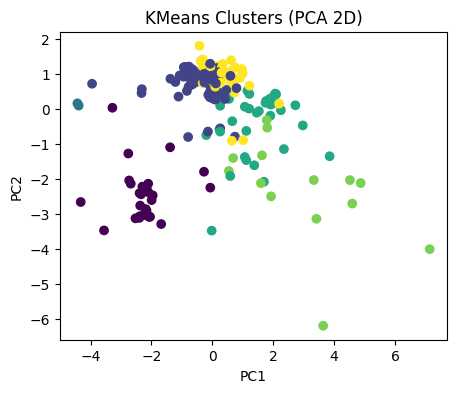

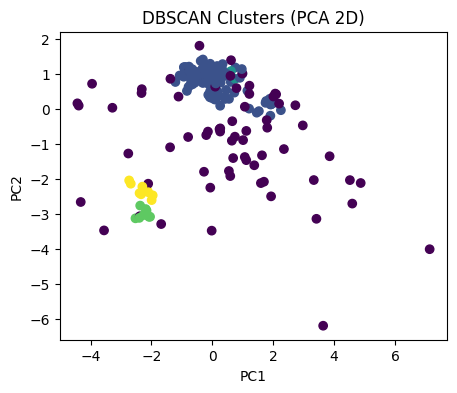

In [24]:
#  PHẦN 4: CHUẨN HÓA DỮ LIỆU & GOM CỤM 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import f1_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

# Đọc dữ liệu và chuẩn hóa (bỏ Id và nhãn)
col_names = ["Id","RI","Na","Mg","Al","Si","K","Ca","Ba","Fe","Type"]
df = pd.read_csv("glass-data.csv", sep="\t", header=0, names=col_names)
X = df.drop(columns=["Id","Type"]).values
y = df["Type"].values

X_scaled = StandardScaler().fit_transform(X)

#  Chạy K-Means và DBSCAN
n_clusters = len(np.unique(y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
km_labels = kmeans.fit_predict(X_scaled)

db = DBSCAN(eps=1.0, min_samples=5)   # eps có thể đổi: 0.8, 1.0, 1.2 để thử
db_labels = db.fit_predict(X_scaled)

# Hàm ánh xạ cụm ↔ nhãn thật (để tính F1)
def best_map(y_true, y_pred):
    labels_true = np.unique(y_true)
    labels_pred = np.unique(y_pred)
    cost = np.zeros((len(labels_pred), len(labels_true)), dtype=int)
    for i, lp in enumerate(labels_pred):
        for j, lt in enumerate(labels_true):
            cost[i,j] = np.sum((y_pred==lp) & (y_true==lt))
    r,c = linear_sum_assignment(cost.max() - cost)
    mapping = {labels_pred[ri]: labels_true[ci] for ri,ci in zip(r,c)}
    y_mapped = np.array([mapping.get(lp,-1) for lp in y_pred])
    return y_mapped, mapping

# Hàm đánh giá gom cụm
def evaluate(y_true, y_pred):
    y_mapped, mapping = best_map(y_true, y_pred)
    return {
        "F1_macro": f1_score(y_true, y_mapped, average="macro"),
        "ARI": adjusted_rand_score(y_true, y_pred),
        "NMI": normalized_mutual_info_score(y_true, y_pred),
        "Mapping": mapping
    }

#  Tính và in kết quả
km_eval = evaluate(y, km_labels)
db_eval = evaluate(y, db_labels)

print("=== KMeans ===")
print(km_eval)
print("\n=== DBSCAN ===")
print(db_eval)

#  Vẽ biểu đồ PCA 2D
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(5,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=km_labels)
plt.title("KMeans Clusters (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

plt.figure(figsize=(5,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels)
plt.title("DBSCAN Clusters (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()
